# Etude de l'impact de la crise sanitaire sur le nombre d'établissments en Grand Est sur chaque secteurs d'activité 

In [1]:
suppressPackageStartupMessages(require(skimr))
suppressPackageStartupMessages(require(readxl))
suppressPackageStartupMessages(require(stringr))
suppressPackageStartupMessages(require(dplyr))
suppressPackageStartupMessages(require(ggplot2))
suppressPackageStartupMessages(require(forecast))


In [2]:
#------------------------------------------------------
# data pre treatment (similar to univariate case)

df <- read_excel("data/data.xlsx",sheet = 3)
tmp <-df%>% filter(aire=="44_GRAND EST" & champ=="ESS")

df <-tmp[-which(!is.na(tmp$secret_stat)),]%>%select(-secret_stat)
df <- df %>% select(-champ,-type_aire,-type_naf,-aire)
df <- df[,c(TRUE,str_detect(colnames(df),"nb_etab")[-1])]
tmp <- t(df)
colnames(tmp) <- tmp[1,]
tmp <-tmp[-1,]
df <- tmp
tmp <-df%>%as.data.frame
tmp <-cbind("date"=rep(NA,nrow(tmp)),tmp)
for (i in 1:nrow(tmp)){
    tmp.format.date <- strsplit(rownames(df)[i],"nb_etab")[[1]][2]
    subsplit <-strsplit(tmp.format.date,"T")[[1]]
    year<-subsplit[1]
    trimester <- subsplit[2]
    month <-switch(trimester,
        "1"="01",
        "2"="04",
        "3"="07",
        "4"="10"
    )
    tmp[i,1] <- paste(year,month,"01",sep="-")
}
tmp$date <-as.Date(tmp$date)
rownames(tmp) <- NULL

df.indexes <-which(tmp$date <= as.Date("2020-01-01"))
train.indexes<- which(tmp$date < as.Date("2018-01-01") )
test.indexes <-which(tmp$date>= as.Date("2018-01-01") & tmp$date <as.Date("2020-01-01") )
tmp <-tmp %>%select(-date)%>% mutate_all(as.numeric)
#----------------------------
# Eliminate total serie
tmp <- tmp[,-ncol(tmp)]
df.ts <- ts(tmp[df.indexes,],start=c(2010,1),frequency=4)# S'arrete à 2019 Q4
train.ts <-ts(tmp[train.indexes,],start=c(2010,1),frequency = 4)# S'arrete à 2017 Q4
test.ts <-ts(tmp[test.indexes,],start = c(2018,1),frequency = 4)# Commence a 2018 Q1 --> 2019 Q4
global.ts <- ts(tmp,start=c(2010,1),frequency=4)# Commence a 2010 Q1 --> 2021 Q2
covid.ts <- ts(tmp[(df.indexes[length(df.indexes)]+1):nrow(tmp),],start=c(2020,1),frequency = 4)# Commence a 2020 Q1 --> 2021 Q2 

In [3]:
suppressPackageStartupMessages(require(vars))

In [4]:
df.ts %>%head
cat("dim : ",dim(df.ts))

,"64 Activités des services financiers, hors assurance et",65-66 Assurance ; Activités auxiliaires de services fin,852 Enseignement primaire,853 Enseignement secondaire,85x Enseignement / Autre,861 Activités hospitalières,862 Activité des médecins et des dentistes,869 Autres activités pour la santé humaine,87 Hébergement médico-social et social,881 Action sociale sans hébergement pour personnes âgée,889 Autre action sociale sans hébergement,931 Activités liées au sport,932 Activités récréatives et de loisirs,FZ_Construction,"GZ_Commerce, réparation d'automobiles et de motocycles",HZ_Transports et entreposage,IZ_Hébergement et restauration,JA_Edition et audiovisuel,JB-JC_Télécommunications et ativités informatiques,LZ_Activités immobilières,"MA_Activités juridiques, de conseil et d'ingénierie",MB-MC_R&d et autres activités scientifiques et techniqu,NZ_Activités de services administratifs et de soutien,"RZ_Arts, spectacles et activités récréatives",SZ_autres activités de services,i_Industrie et agriculture
2010 Q1,1290,355,70,156,1183,94,135,123,898,573,1435,1431,209,45,306,17,261,109,18,32,211,67,338,978,3087,49
2010 Q2,1284,354,72,156,1192,92,136,124,897,570,1451,1445,213,42,302,17,263,112,19,30,212,69,341,1019,3154,50
2010 Q3,1279,356,72,156,1147,92,148,126,902,572,1462,1382,228,42,319,17,299,109,19,32,205,71,346,996,3119,54
2010 Q4,1278,347,72,156,1185,94,139,125,905,573,1435,1459,212,42,315,17,252,112,19,32,199,71,345,1023,3133,51
2011 Q1,1276,393,71,155,1168,99,150,124,902,565,1437,1438,209,43,307,17,254,111,20,29,198,71,341,1002,3056,49
2011 Q2,1274,394,71,153,1179,98,151,125,908,561,1439,1410,208,41,303,17,255,110,17,29,204,69,346,1035,3107,47


dim :  41 26

En multivarié on est en présence d'un processus de 26 dimensions de longueur $T=40$

**Dans un premier temps nous allons continuer notre démarche naîvement , en ne prenant pas compte le problème de dimension induit par un processus de 27 dimensions**

<hr>

## I. Statistiques descriptives de notre processus

In [5]:
mean(df.ts[,1])

[1] 1196.293

In [6]:
ts.means  <- apply(df.ts,2,mean)%>% as.data.frame()
names(ts.means) <- "mean"
ts.means


,mean
,<dbl>
"64 Activités des services financiers, hors assurance et",1196.29268
65-66 Assurance ; Activités auxiliaires de services fin,386.90244
852 Enseignement primaire,69.04878
853 Enseignement secondaire,147.87805
85x Enseignement / Autre,1143.97561
861 Activités hospitalières,97.90244
862 Activité des médecins et des dentistes,160.34146
869 Autres activités pour la santé humaine,131.63415
87 Hébergement médico-social et social,940.85366


In [7]:
apply(df.ts,2,summary)

,"64 Activités des services financiers, hors assurance et",65-66 Assurance ; Activités auxiliaires de services fin,852 Enseignement primaire,853 Enseignement secondaire,85x Enseignement / Autre,861 Activités hospitalières,862 Activité des médecins et des dentistes,869 Autres activités pour la santé humaine,87 Hébergement médico-social et social,881 Action sociale sans hébergement pour personnes âgée,⋯,IZ_Hébergement et restauration,JA_Edition et audiovisuel,JB-JC_Télécommunications et ativités informatiques,LZ_Activités immobilières,"MA_Activités juridiques, de conseil et d'ingénierie",MB-MC_R&d et autres activités scientifiques et techniqu,NZ_Activités de services administratifs et de soutien,"RZ_Arts, spectacles et activités récréatives",SZ_autres activités de services,i_Industrie et agriculture
Min.,1060.000,347.0000,66.00000,144.000,1055.000,92.00000,135.0000,123.0000,897.0000,547.0000,⋯,210.0000,103.0000,11.00000,24.00000,188.000,58.00000,278.0000,977.000,2835.000,47.0000
1st Qu.,1136.000,381.0000,68.00000,145.000,1110.000,97.00000,152.0000,127.0000,919.0000,551.0000,⋯,218.0000,109.0000,15.00000,28.00000,195.000,61.00000,302.0000,1000.000,3047.000,53.0000
Median,1208.000,390.0000,69.00000,146.000,1161.000,98.00000,159.0000,133.0000,942.0000,552.0000,⋯,229.0000,112.0000,17.00000,30.00000,198.000,65.00000,325.0000,1023.000,3103.000,55.0000
Mean,1196.293,386.9024,69.04878,147.878,1143.976,97.90244,160.3415,131.6341,940.8537,554.3415,⋯,235.2927,111.4634,16.60976,30.26829,198.439,65.19512,318.7073,1023.049,3066.415,56.2439
3rd Qu.,1257.000,394.0000,70.00000,148.000,1179.000,99.00000,173.0000,136.0000,959.0000,555.0000,⋯,246.0000,113.0000,18.00000,32.00000,202.000,69.00000,335.0000,1039.000,3133.000,58.0000
Max.,1318.000,418.0000,73.00000,157.000,1206.000,101.00000,181.0000,141.0000,988.0000,573.0000,⋯,299.0000,121.0000,20.00000,35.00000,212.000,75.00000,350.0000,1081.000,3168.000,72.0000


 L'on va rename les label de chaque secteurs d'activité afin de garder les prochains graphes lisibles

In [8]:
colnames(df.ts) %>%length

[1] 26

In [9]:
print("CORRESPONDANCE LABEL - NOMBRE SECTEURS")
lab.to.num <-cbind("lab"=colnames(df.ts),"num"=1:length(colnames(df.ts))) %>%as.data.frame
lab.to.num$num <- as.numeric(lab.to.num$num)
lab.to.num

[1] "CORRESPONDANCE LABEL - NOMBRE SECTEURS"


lab,num
<chr>,<dbl>
"64 Activités des services financiers, hors assurance et",1
65-66 Assurance ; Activités auxiliaires de services fin,2
852 Enseignement primaire,3
853 Enseignement secondaire,4
85x Enseignement / Autre,5
861 Activités hospitalières,6
862 Activité des médecins et des dentistes,7
869 Autres activités pour la santé humaine,8
87 Hébergement médico-social et social,9


In [10]:
colnames(df.ts) <-lab.to.num$num

Loading required package: corrplot

corrplot 0.92 loaded



lab,num
<chr>,<dbl>
"64 Activités des services financiers, hors assurance et",1
65-66 Assurance ; Activités auxiliaires de services fin,2
852 Enseignement primaire,3
853 Enseignement secondaire,4
85x Enseignement / Autre,5
861 Activités hospitalières,6
862 Activité des médecins et des dentistes,7
869 Autres activités pour la santé humaine,8
87 Hébergement médico-social et social,9


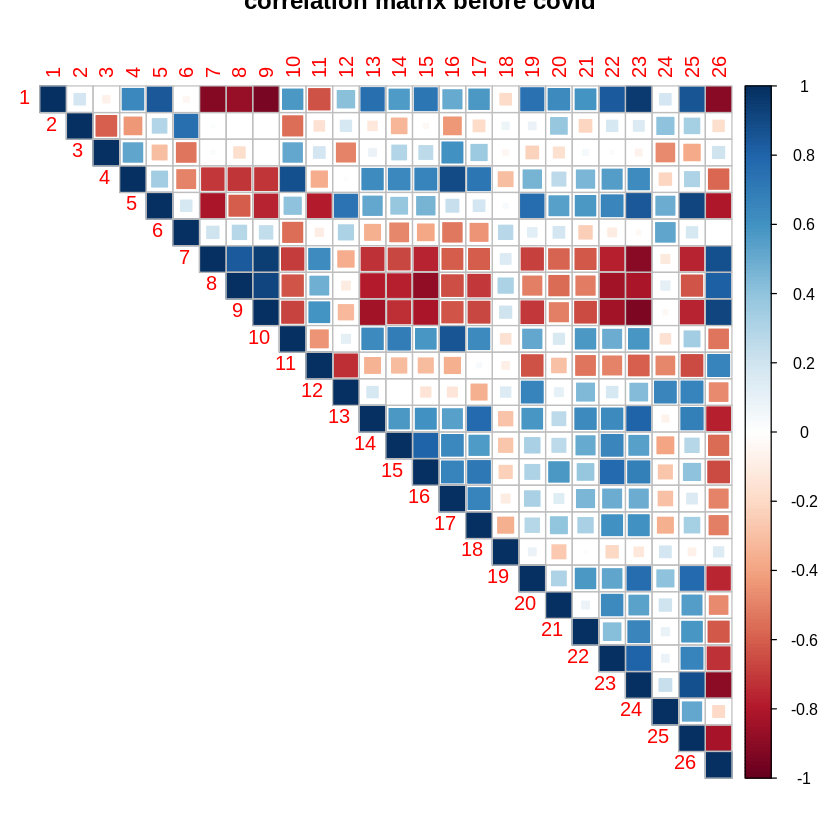

In [11]:
require(corrplot)
mcor <- cor(df.ts)
corrplot(mcor,method="square",type = "upper", title="correlation matrix before covid")
lab.to.num

On peux voir qu'il y a des correlations plutot importantes entre nos différents secteurs d'activités.

Ceci montre qu'une analyse en multivarié à un interets. **En effets, étudier ces processus en multivariés permet de prendre en considerations les liens entre chaqun de ses processus afin de batir de meilleures prédiction qu'en univarié**

Regardons par la même occasion les statistiques lors de la période covid.

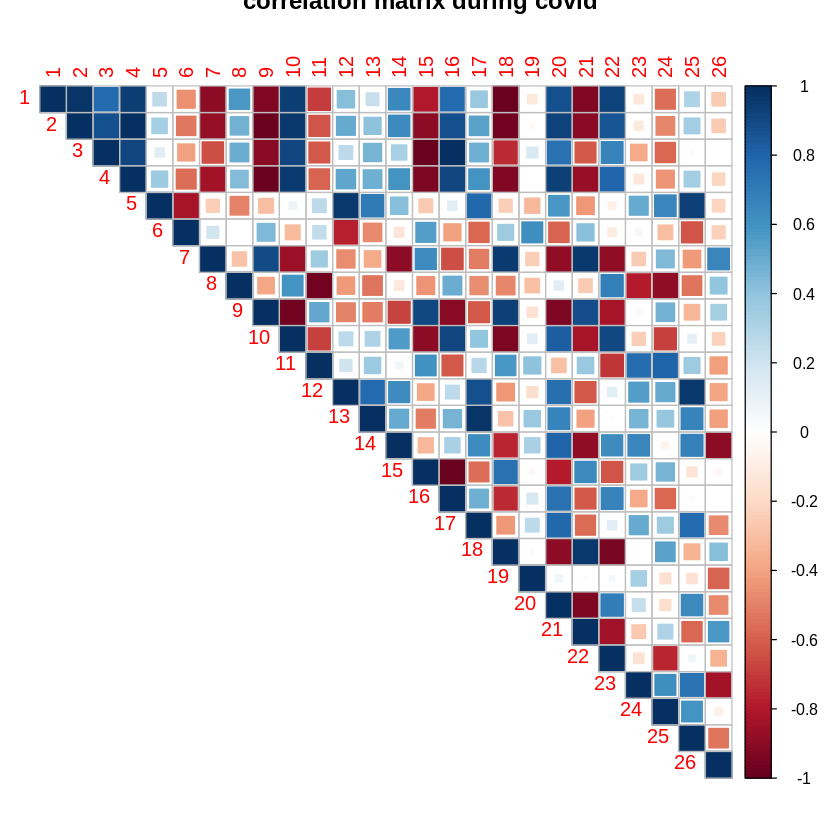

In [12]:
colnames(covid.ts) <- lab.to.num$num
mcor.covid <- cor(covid.ts)
corrplot(mcor.covid,method="square",type = "upper",title="correlation matrix during covid")

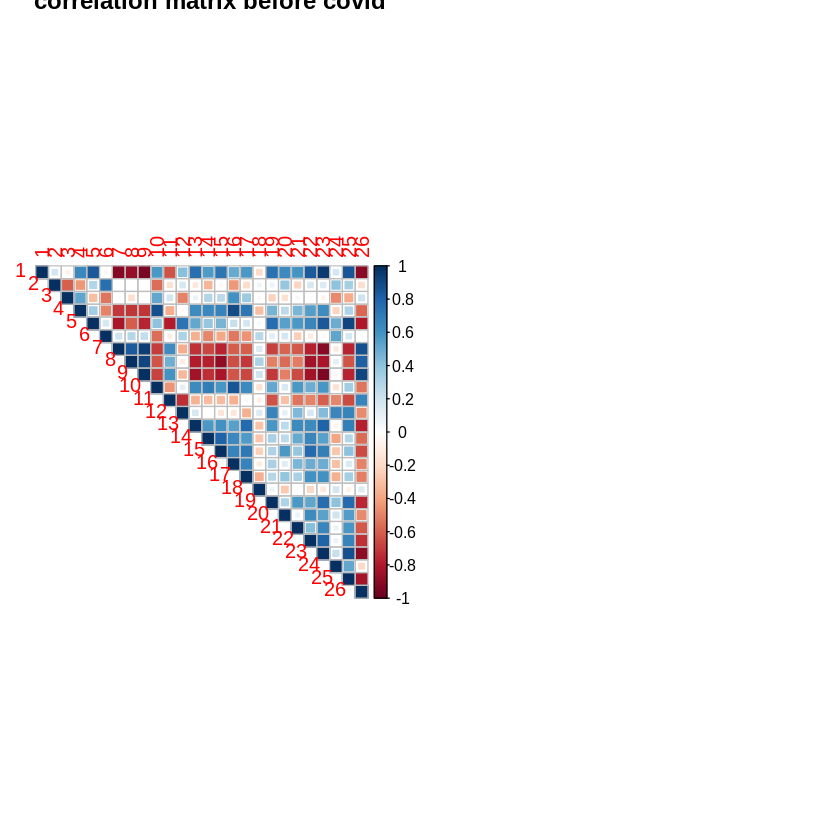

In [13]:
par(mfrow=c(1,2),mar=c(5,4,4,2))
#corrplot(mcor.covid,method="square",type = "upper",title="correlation matrix during covid")
corrplot(mcor,method="square",type = "upper", title="correlation matrix before covid")

 <hr>

## II.B. Multivariate TS Analysis

In [14]:
test <-ur.df(df.ts[,1],type="none")
#summary(test)
print("Critical value ---------------")
cval <-attr(test,"cval")
cval

cval <-cval[1,3]
print(" Stat Test -----------------")
T_stat <- attr(test,"teststat")
T_stat
T_stat <- T_stat[1,1]
# Si test stat > Cval on n peux rejeter Ho : Présence d'unit root 
# Sinon on puex rejeter Ho : Stationnarité



# Dans notre cas : test Val > critical values : On peux rejeter l'hypothese d'une racine unitaire
if(T_stat >cval){
    print("Présence d'unit root")
}

[1] "Critical value ---------------"


,1pct,5pct,10pct
tau1,-2.62,-1.95,-1.61


[1] " Stat Test -----------------"


,tau1
statistic,-2.291616


In [15]:
alpha <- 0.1
stationary.list.1 <- list(
    "stable" = c(),
    "non-stable"=c()
)
stationary.list.2 <- list(
    "stable" = c(),
    "non-stable"=c()
)
stationary.list.3 <- list(
    "stable" = c(),
    "non-stable"=c()
)


for (index in 1: dim(df.ts)[2]){
    i <- df.ts[,index]
    test.1 <-ur.df(i,type="none")
    test.2 <-ur.df(i,type="drift")
    test.3 <-ur.df(i,type="trend")
    cval.1 <-attr(test.1,"cval")
    cval.2 <-attr(test.2,"cval")
    cval.3 <-attr(test.3,"cval")
    cval.1 <-cval.1[1,3]
    cval.2 <-cval.2[1,3]
    cval.3 <-cval.3[1,3]


    T_stat.1 <- attr(test.1,"teststat")
    T_stat.2 <- attr(test.2,"teststat")
    T_stat.3 <- attr(test.3,"teststat")
    T_stat.1 <- T_stat.1[1,1]
    T_stat.2 <- T_stat.2[1,1]
    T_stat.3 <- T_stat.3[1,1]

    bool.1<-T_stat.1 < cval.1# Test modele none
    bool.2<-T_stat.2 < cval.2# Test modele drift
    bool.3<-T_stat.3 < cval.3# Test modele Trend
    
    if (bool.1){
        stationary.list.1[["stable"]]<- c(stationary.list.1[["stable"]],colnames(df.ts)[index])
    }else{
        stationary.list.1[["non-stable"]]<- c(stationary.list.1[["non-stable"]],colnames(df.ts)[index])    
    }
    if (bool.2){
        stationary.list.2[["stable"]]<- c(stationary.list.2[["stable"]],colnames(df.ts)[index])
    }else{
        stationary.list.2[["non-stable"]]<- c(stationary.list.2[["non-stable"]],colnames(df.ts)[index])    
    }

    if (bool.3){
        stationary.list.3[["stable"]]<- c(stationary.list.3[["stable"]],colnames(df.ts)[index])
    }else{
        stationary.list.3[["non-stable"]]<- c(stationary.list.3[["non-stable"]],colnames(df.ts)[index])    
    }
    
}



In [16]:
print("Test modele none")
stationary.list.1

print("Test modele drift")
stationary.list.2
print("Test modele trend")
stationary.list.3

[1] "Test modele none"


$stable
[1] "1"  "23" "25"

$`non-stable`
 [1] "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15" "16"
[16] "17" "18" "19" "20" "21" "22" "24" "26"

[1] "Test modele drift"


$stable
[1] "6"  "10" "18" "21"

$`non-stable`
 [1] "1"  "2"  "3"  "4"  "5"  "7"  "8"  "9"  "11" "12" "13" "14" "15" "16" "17"
[16] "19" "20" "22" "23" "24" "25" "26"

[1] "Test modele trend"


$stable
[1] "6"  "7"  "17" "18" "21" "22"

$`non-stable`
 [1] "1"  "2"  "3"  "4"  "5"  "8"  "9"  "10" "11" "12" "13" "14" "15" "16" "19"
[16] "20" "23" "24" "25" "26"

Aucun n'est stationnaire

In [17]:
diff.df.ts <-diff(df.ts)

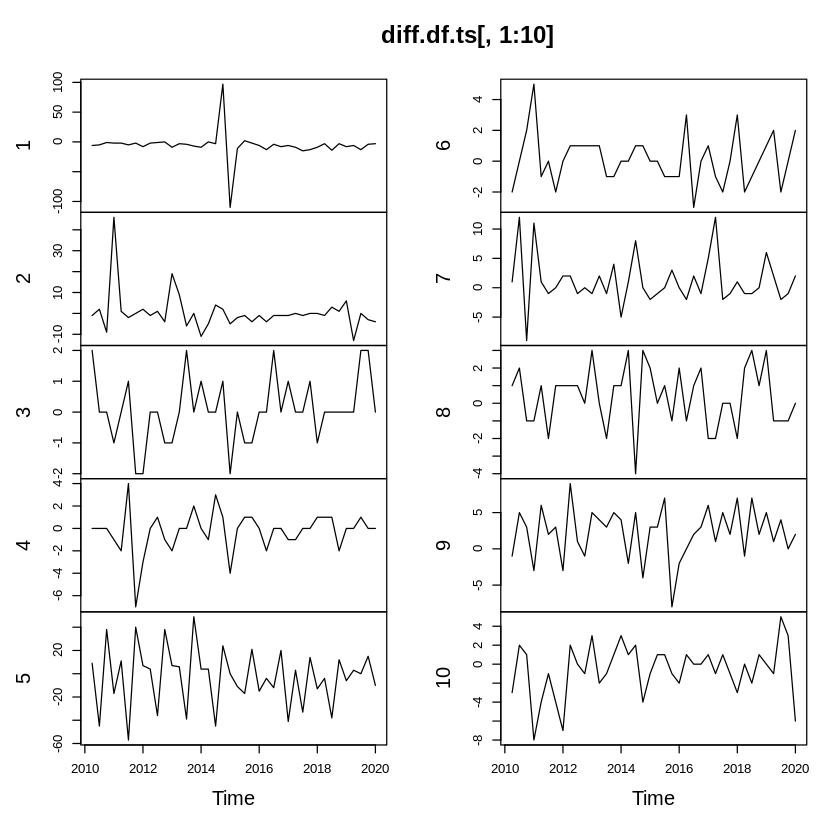

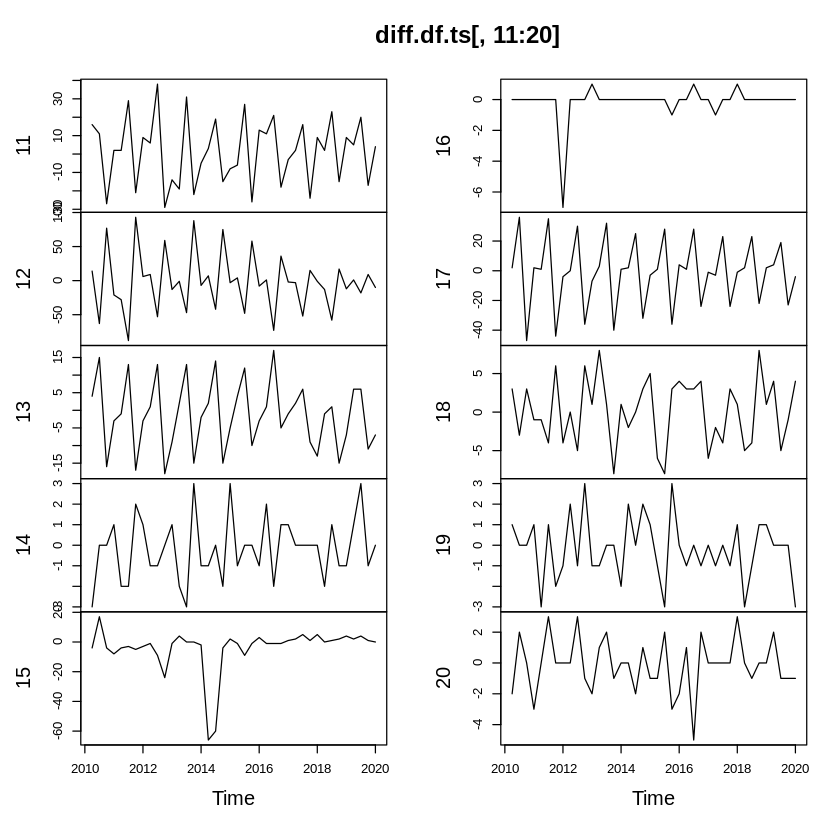

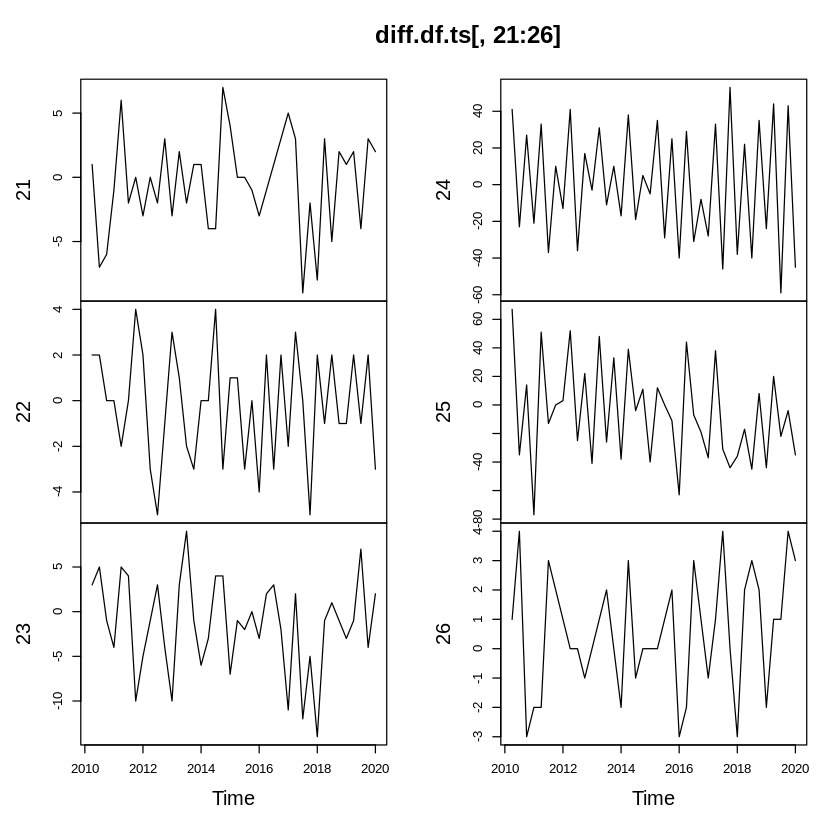

In [18]:
plot.ts(diff.df.ts[,1:10])
plot.ts(diff.df.ts[,11:20])
plot.ts(diff.df.ts[,21:26])

In [19]:
alpha <- 0.1
stationary.list.1 <- list(
    "stable" = c(),
    "non-stable"=c()
)
stationary.list.2 <- list(
    "stable" = c(),
    "non-stable"=c()
)
stationary.list.3 <- list(
    "stable" = c(),
    "non-stable"=c()
)


for (index in 1: dim(df.ts)[2]){
    i <- diff.df.ts[,index]
    test.1 <-ur.df(i,type="none")
    test.2 <-ur.df(i,type="drift")
    test.3 <-ur.df(i,type="trend")
    cval.1 <-attr(test.1,"cval")
    cval.2 <-attr(test.2,"cval")
    cval.3 <-attr(test.3,"cval")
    cval.1 <-cval.1[1,3]
    cval.2 <-cval.2[1,3]
    cval.3 <-cval.3[1,3]


    T_stat.1 <- attr(test.1,"teststat")
    T_stat.2 <- attr(test.2,"teststat")
    T_stat.3 <- attr(test.3,"teststat")
    T_stat.1 <- T_stat.1[1,1]
    T_stat.2 <- T_stat.2[1,1]
    T_stat.3 <- T_stat.3[1,1]

    bool.1<-T_stat.1 < cval.1
    bool.2<-T_stat.2 < cval.2
    bool.3<-T_stat.3 < cval.3
    
    if (bool.1){
        stationary.list.1[["stable"]]<- c(stationary.list.1[["stable"]],colnames(df.ts)[index])
    }else{
        stationary.list.1[["non-stable"]]<- c(stationary.list.1[["non-stable"]],colnames(df.ts)[index])    
    }
    if (bool.2){
        stationary.list.2[["stable"]]<- c(stationary.list.2[["stable"]],colnames(df.ts)[index])
    }else{
        stationary.list.2[["non-stable"]]<- c(stationary.list.2[["non-stable"]],colnames(df.ts)[index])    
    }

    if (bool.3){
        stationary.list.3[["stable"]]<- c(stationary.list.3[["stable"]],colnames(df.ts)[index])
    }else{
        stationary.list.3[["non-stable"]]<- c(stationary.list.3[["non-stable"]],colnames(diff.df.ts)[index])    
    }
    
}


In [20]:
print("test modele none")
stationary.list.1
print("test modele drift")
stationary.list.2
print("test modele trend")
stationary.list.3

[1] "test modele none"


$stable
 [1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "23" "24" "25" "26"

$`non-stable`
NULL

[1] "test modele drift"


$stable
 [1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "23" "24" "25" "26"

$`non-stable`
NULL

[1] "test modele trend"


$stable
 [1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "23" "24" "25" "26"

$`non-stable`
NULL

Utilisation de la differenciation du premeir ordre pour les compasants non stationnaire. Cette differnciation semble avoir permier de stationnarisé l'ensemble des processus

<hr>

## Le probleme : 



In [21]:

Ps <-3:4
mod.tmp <- vars::VAR(diff.df.ts,Ps[1],type="const",ic=c("AIC","SC","FPE"))
#summary(mod.tmp)
mod.tmp


VAR Estimation Results:

Estimated coefficients for equation X1: 
Call:
X1 = X1.l1 + X2.l1 + X3.l1 + X4.l1 + X5.l1 + X6.l1 + X7.l1 + X8.l1 + X9.l1 + X10.l1 + X11.l1 + X12.l1 + X13.l1 + X14.l1 + X15.l1 + X16.l1 + X17.l1 + X18.l1 + X19.l1 + X20.l1 + X21.l1 + X22.l1 + X23.l1 + X24.l1 + X25.l1 + X26.l1 + X1.l2 + X2.l2 + X3.l2 + X4.l2 + X5.l2 + X6.l2 + X7.l2 + X8.l2 + X9.l2 + X10.l2 + X11.l2 + X12.l2 + X13.l2 + X14.l2 + X15.l2 + X16.l2 + X17.l2 + X18.l2 + X19.l2 + X20.l2 + X21.l2 + X22.l2 + X23.l2 + X24.l2 + X25.l2 + X26.l2 + X1.l3 + X2.l3 + X3.l3 + X4.l3 + X5.l3 + X6.l3 + X7.l3 + X8.l3 + X9.l3 + X10.l3 + X11.l3 + X12.l3 + X13.l3 + X14.l3 + X15.l3 + X16.l3 + X17.l3 + X18.l3 + X19.l3 + X20.l3 + X21.l3 + X22.l3 + X23.l3 + X24.l3 + X25.l3 + X26.l3 + const 

      X1.l1       X2.l1       X3.l1       X4.l1       X5.l1       X6.l1 
  0.4608110   1.5445191  -3.3611431  -4.6793148   0.5311481 -19.3491404 
      X7.l1       X8.l1       X9.l1      X10.l1      X11.l1      X12.l1 
  1.0113098 -11.5757

Il y a trop de parametre à estimer 
On doit forcement reduire le nombre dimension

Ce que l'on peux faire : Ce cantonner a des processus de dimension K=4.
Combien  y a t il de composition possible jusqu'alors:

Pour chaque variables : $1*25*24*23 = 13800$

Autrement dit au total on a : $13800*26$ modeles possibles soit $358 800$ possibilités

Pour chaque variables on choisit celui étant le meilleur, et on le conserve.
 




### **Une solution ?**

In [32]:
#--------------------------------
# Getting all combinaison possible for every var
mod.list <- list()

for(var_index in 1:26){
    all_combinaison <- data.frame("VAR1"=c(NA),"VAR2"=c(NA),"VAR3"=c(NA),"VAR4"=c(NA))
    
    all_vars <-1:26
    residual_vars <-which(all_vars !=var_index)

    for(num in residual_vars){

        second_var <- num
        poss_var_2 <- residual_vars[-which(residual_vars ==second_var)]

        for(num_2 in poss_var_2){

            third_var <- num_2
            poss_var_3 <- residual_vars[-which(residual_vars ==third_var | residual_vars== second_var)]

            for (num_3 in poss_var_3){

                fourth_var <- num_3
                #print(c(var_index,second_var,third_var,fourth_var))
                all_combinaison<-rbind(all_combinaison,c(var_index,second_var,third_var,fourth_var))
            }

        }

    }
    all_combinaison <- all_combinaison[-1,]
    all_combinaison_tmp <-apply(all_combinaison,1,function(x){sort(x)})%>%t()

    all_combinaison_tmp<- all_combinaison_tmp%>%as.data.frame
    tmp <-NULL
    tmp <-distinct(all_combinaison_tmp)
    all_combinaison <-tmp
    colnames(all_combinaison) <- paste("VAR",1:4,sep="")
    evals_models <- data.frame("VAR"=c(NA),"MOD_COMBINATION"=c(NA),
        "adequate"=c(NA),
        "p.val"=c(NA),
        "ME"=c(NA),
        "RMSE"=c(NA),
        "MAE"=c(NA),
        "MPE"=c(NA),
        "MAPE"=c(NA),
        "MASE"=c(NA),
        "AIC"=c(NA),
        "loglik"=c(NA)
    )

    for(row_index in 1:nrow(all_combinaison)){
    
        #--------------------------------------------
        # Fit a var for every combinaison 

        row <-unlist(all_combinaison[row_index,])
        row <- as.numeric(row)

        #----------------------
        # LAG SELECTION
        selection <-VARselect(
            cbind(
                diff.df.ts[,row[1]],
                diff.df.ts[,row[2]],
                diff.df.ts[,row[3]],
                diff.df.ts[,row[4]]
            ),
            type="const",
            lag.max=6

        )
        p <-selection$selection[1]
        p <-p%>%as.numeric
        #--------------------------
        # FIT THE MODEL
        mod.tmp <-vars::VAR(
            cbind(
                diff.df.ts[,row[1]],
                diff.df.ts[,row[2]],
                diff.df.ts[,row[3]],
                diff.df.ts[,row[4]]
            ),
            p,
            type = "const",
            ic=c("AIC","SC","FPE")
        )
        #--------------------------
        # Test for VAR Hypothesis
        port.test <-serial.test(mod.tmp,type="PT.asymptotic")
        p.val <- port.test$serial$p.value
        alpha <- 0.05
        if(p.val >0.05){
            adequate <- "adequate"
        }else{
            adequate <- "non adequate"
        }

        if(adequate=="non adequate"){
                test <-ca.jo(
                cbind(
                    df.ts[,row[1]],
                    df.ts[,row[2]],
                    df.ts[,row[3]],
                    df.ts[,row[4]]
                ),
                K=p,
                type=c("eigen"),
                ecdet = "none"
            )
            cval <-attr(test,"cval")
            tStat <- attr(test,"teststat")
            for(i in seq(nrow(cval),1,-1)){
                cval_tmp <- cval[i,2]
                tStat_tmp <- tStat[i]

                if(cval_tmp >= tStat_tmp){
                    break;
                }

            }
            r=nrow(cval)-i
    
            if(r==0){
                # No cointegration space
                print(paste("Warning combianision: ",row_index,sep=""))
                mod.tmp <-vars::VAR(
                    cbind(
                        diff.df.ts[,row[1]],
                        diff.df.ts[,row[2]],
                        diff.df.ts[,row[3]],
                        diff.df.ts[,row[4]]
                    ),
                    p,
                    type = "const",
                    ic=c("AIC","SC","FPE")
                )
                combi <-paste(
                    row[1],
                    row[2],
                    row[3],
                    row[4],sep="_"
                )
                port.test <-serial.test(mod.tmp,type="PT.asymptotic")
                p.val <- port.test$serial$p.value
                alpha <- 0.05
                if(p.val >0.05){
                    adequate <- "adequate"
                }else{
                    adequate <- "non adequate"
                }
                evals <-cbind(
                    "VAR"=var_index,
                    "MOD_COMBINATION"=combi,
                    "adequate"=adequate,
                    "p.val"=p.val,
                    accuracy(mod.tmp$varresult[[1]]),
                    "AIC"=AIC(mod.tmp),
                    "loglik"=logLik(mod.tmp) %>% as.numeric()
                )

            }else{
                #----------------------------
                # Then we fit the VECM model 
                # Warning : With the non differenciate data
                mod.tmp <-vec2var(test,r=r)
                
                # Forme des residu
                #hist(mod.bis.bis$res[,1])
                combi <-paste(
                    row[1],
                    row[2],
                    row[3],
                    row[4],sep="_"
                )
                port.test <-serial.test(mod.tmp,type="PT.asymptotic")
                p.val <- port.test$serial$p.value
                alpha <- 0.05
                if(p.val >0.05){
                    adequate <- "adequate"
                }else{
                    adequate <- "non adequate"
                }
                
                evals <-cbind(
                    "VAR"=var_index,
                    "MOD_COMBINATION"=combi,
                    "adequate"=paste(adequate,"VECM",sep=""),
                    "p.val"=p.val,
                    "ME"=NA,
                    "RMSE"=NA,
                    "MAE"=NA,
                    "MPE"=NA,
                    "MAPE"=NA,
                    "MASE"=NA,
                    "AIC"=AIC(mod.tmp),
                    "loglik"=logLik(mod.tmp) %>% as.numeric()
                )

            }
            
    

        }else{
            #-------------------------
            #Evaluation model 
            combi <-paste(
                    row[1],
                    row[2],
                    row[3],
                    row[4],sep="_"
            )
            evals <-cbind(
                "VAR"=var_index,
                "MOD_COMBINATION"=combi,
                "adequate"=adequate,
                "p.val"=p.val,
                accuracy(mod.tmp$varresult[[1]]),
                "AIC"=AIC(mod.tmp),
                "loglik"=logLik(mod.tmp) %>% as.numeric()
            )
        }
    

    
        evals_models<- rbind(evals_models,evals)
        # Still in the loop for each combianison
        saveRDS(mod.tmp,file=paste("VAR_VECM_models/models/tmp/",row_index,".Rda",sep=""))

    


    }
    evals_models <- evals_models[-1,]
    evals_models.tmp <-evals_models %>% filter(adequate %in% c("adequateVECM","adequate"))
    selected_mod <-evals_models.tmp[which.min(evals_models.tmp$AIC),]
    index_evals_mod <-which(evals_models$MOD_COMBINATION==selected_mod$MOD_COMBINATION)
    mod <- readRDS(paste("VAR_VECM_models/models/tmp/",index_evals_mod,".Rda",sep=""))
    saveRDS(mod,file=paste("VAR_VECM_models/models/",var_index,".Rda",sep=""))
    mod.list <- append(mod.list,list(c(selected_mod)))
    

}


#------------------------------------------------------------------------
#From a matrix containing all the selected models informations

mod.eval.df <- data.frame(
"VAR"=c(NA),
"MOD_COMBINATION"=c(NA),
"adequate"=c(NA),
"p.val"=c(NA),
"ME"=c(NA),
"RMSE"=c(NA),
"MAE"=c(NA),
"MPE"=c(NA),
"MAPE"=c(NA),
"MASE"=c(NA),
"AIC"=c(NA),
"loglik"=c(NA)
)


for(i in 1:(mod.list%>%length)){
    mod.eval.df <- rbind(mod.eval.df,c(
        mod.list[[i]]$VAR,
        mod.list[[i]]$MOD_COMBINATION,
        mod.list[[i]]$adequate,
        mod.list[[i]]$p.val,
        mod.list[[i]]$ME,
        mod.list[[i]]$RMSE,
        mod.list[[i]]$MAE,
        mod.list[[i]]$MPE,
        mod.list[[i]]$MAPE,
        mod.list[[i]]$MASE,
        mod.list[[i]]$AIC,
        mod.list[[i]]$loglik
    ))
}
#-----------------------------
#Save evals reuslts

saveRDS(mod.eval.df[-1,],"VAR_VECM_models/df_eval_mod_VAR.Rda")



[1] "Warning combianision: 53"
[1] "Warning combianision: 562"
[1] "Warning combianision: 720"
[1] "Warning combianision: 793"
[1] "Warning combianision: 804"
[1] "Warning combianision: 872"
[1] "Warning combianision: 928"
[1] "Warning combianision: 999"
[1] "Warning combianision: 1092"
[1] "Warning combianision: 1112"
[1] "Warning combianision: 1288"
[1] "Warning combianision: 1645"
[1] "Warning combianision: 1813"
[1] "Warning combianision: 1874"
[1] "Warning combianision: 1982"
[1] "Warning combianision: 2028"
[1] "Warning combianision: 53"
[1] "Warning combianision: 531"
[1] "Warning combianision: 537"
[1] "Warning combianision: 547"
[1] "Warning combianision: 582"
[1] "Warning combianision: 647"
[1] "Warning combianision: 716"
[1] "Warning combianision: 719"
[1] "Warning combianision: 722"
[1] "Warning combianision: 732"
[1] "Warning combianision: 794"
[1] "Warning combianision: 805"
[1] "Warning combianision: 906"
[1] "Warning combianision: 1196"
[1] "Warning combianision: 1287"


In [36]:
for (i in 1:26){
    mod <-readRDS(paste("VAR_VECM_models/models/",i,".Rda",sep=""))   
    #print(mod)
    
    previsions <-predict(mod)
    print(previsions)
    row_eval <-mod.eval.df%>%filter(VAR==i)
    #print(row_eval)
    combi <-row_eval$MOD_COMBINATION
    
    numbers.combi <-strsplit(combi,"[_]")[[1]]
    
    #print(previsions)
    for (j in 1:(numbers.combi%>% length)){


        if(as.numeric(numbers.combi[j])==i){
            break;
        }

    }
    
    #print(j)

    #--------------------------
    #i is the row considered for our var in the models
    #plot(previsions)
    prev <- previsions[[1]]
    prev <- prev[[j]]
    #print(prev)
    ic_lower <-prev[,2]
    ic_high <-prev[,3]
    frct <- prev[,1]
    frct <- frct[1:5]
    ic_lower<- ic_lower[1:5]
    ic_high <- ic_high[1:5]
    
    if(row_eval$adequate!="adequateVECM"){
        # On a dans ce cas la serie differencier 
        print("To differenciate")
        var.ts <- diff.df.ts[,i]
        obs <- global.ts[,i]
        frct <- c(var.ts,frct) %>% ts(start=c(2010,2),frequency=4)
        ic_lower <- c(var.ts,ic_lower) %>% ts(start=c(2010,2),frequency=4)
        ic_high <- c(var.ts,ic_high) %>% ts(start=c(2010,2),frequency=4)
        frct <- diffinv(frct,xi=obs[1])
        ic_lower <- diffinv(ic_lower,xi=obs[1])
        ic_high <- diffinv(ic_high,xi=obs[1])
    }else{
        # Pas besoin de differencier
        
        var.ts <- df.ts[,i]
        obs <-global.ts[,i]
        frct <- c(var.ts,frct)%>%ts(start=c(2010,1),frequency=4)
        ic_high <- c(var.ts,ic_high)%>%ts(start=c(2010,1),frequency=4)
        ic_lower <- c(var.ts,ic_lower)%>%ts(start=c(2010,1),frequency=4)
    }
    print(frct)
    print(obs)
    png(file=paste("VAR_VECM_models/forecasts/",i,".png",sep=""))
    plot.ts(
            cbind(frct,obs,ic_lower,ic_high),
            plot.type="single",
            lty=c(2,1,3,3),
            lwd=1,
            xlab="t",
            ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[i],sep=""),
    
            col=c("blue","red","darkgreen","darkgreen")
    )
    legend("topleft",
        legend=c("Prédictions","Observations","IC 95%"),
        col=c("blue","red","darkgreen"),
        lty=c(2,1,3),
        lwd=1
    )
    dev.off()
}



$diff.df.ts...row.1..
           fcst      lower     upper       CI
 [1,]  48.56271   15.02463  82.10079 33.53808
 [2,] -76.92007 -130.02334 -23.81680 53.10327
 [3,] -44.33412 -102.71978  14.05154 58.38566
 [4,] -24.87659  -94.10547  44.35229 69.22888
 [5,]  46.87778  -30.04489 123.80045 76.92267
 [6,] -23.78151 -104.64736  57.08433 80.86584
 [7,] -23.33829 -107.57875  60.90218 84.24047
 [8,]  11.22250  -79.87136 102.31636 91.09386
 [9,]  45.52356  -46.86551 137.91264 92.38907
[10,] -11.78793 -106.48529  82.90942 94.69735

$diff.df.ts...row.2..
             fcst     lower    upper       CI
 [1,]  0.17479682 -1.733518 2.083112 1.908315
 [2,] -1.06870340 -3.357526 1.220119 2.288822
 [3,] -0.01746087 -2.377292 2.342370 2.359831
 [4,] -1.34682118 -3.951296 1.257654 2.604475
 [5,] -1.41697366 -4.028711 1.194763 2.611737
 [6,] -0.13090665 -2.865439 2.603626 2.734532
 [7,]  1.52878273 -1.444090 4.501656 2.972873
 [8,]  2.44325964 -0.703444 5.589963 3.146704
 [9,]  0.35092195 -2.886913 3.58875

In [35]:
mod.eval.df

VAR,MOD_COMBINATION,adequate,p.val,ME,RMSE,MAE,MPE,MAPE,MASE,AIC,loglik
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,1_3_14_16,adequate,0.347994159319215,-2.4156024402977e-16,8.80383525073721,6.06343485690281,NaN,Inf,0.629316815817889,575.726530501229,-187.863265250615
2,2_3_6_19,adequateVECM,0.0566289429927427,NA,NA,NA,NA,NA,NA,512.525020728004,-156.262510364002
3,3_4_14_16,adequate,0.0603280876957761,5.38754683282754e-17,0.392580227250646,0.302265465763126,NaN,Inf,0.436773598027717,416.625786191555,-108.312893095777
4,3_4_14_16,adequate,0.0603280876957761,5.38754683282754e-17,0.392580227250646,0.302265465763126,NaN,Inf,0.436773598027717,416.625786191555,-108.312893095777
5,3_5_22_26,adequateVECM,0.0508721347224577,NA,NA,NA,NA,NA,NA,577.388945369446,-188.694472684723
6,3_6_14_19,adequate,0.0682236660789726,6.36457567038832e-17,0.498168938280927,0.376375474427744,NaN,Inf,0.543862560548091,430.582941278616,-115.291470639308
7,3_6_7_20,adequate,0.0706858167008297,1.04083408558608e-17,0.428613127412357,0.340951913027863,NaN,Inf,0.492675514325262,465.479380229778,-132.739690114889
8,3_8_16_19,adequate,0.0992652032705541,-3.06143616380797e-17,0.354362834551248,0.271776200502763,NaN,Inf,0.392716609726493,428.438374143377,-114.219187071688


In [12]:
#-------------------------
#Nombre de parametre a estimer pour chaque variable : 
K=4
p.selected <- c()
for(i in 1: 26){
    mod <-readRDS(
        paste("VAR_VECM_models/models/",i,".Rda",sep="")
    )
    p.selected <- c(p.selected,mod$p)

    
}
#p.selected
K + (K^2)*p.selected + K*(K + 1)/2 
# On a donc 110 parametre pour chaque variables



[1] 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110
[20] 110 110 110 110 110 110 110


<hr> 
<hr>

Brouillon

In [ ]:
#tsCV()
#forecast(mod.tmp,h=5)

In [ ]:
##--------------------------------------------
## Fit a var for every combinaison 
#row_index <-1
#row <-unlist(all_combinaison[row_index,])
#row <- as.numeric(row)
##----------------------
## LAG SELECTION
#selection <-VARselect(
#    cbind(
#        diff.df.ts[,row[1]],
#        diff.df.ts[,row[2]],
#        diff.df.ts[,row[3]],
#        diff.df.ts[,row[4]]
#    ),
#    type="const",
#    lag.max=6
#)
#p <-selection$selection[1]
#p <-p%>%as.numeric
##--------------------------
## FIT THE MODEL
#mod.tmp <-vars::VAR(
#    cbind(
#        diff.df.ts[,row[1]],
#        diff.df.ts[,row[2]],
#        diff.df.ts[,row[3]],
#        diff.df.ts[,row[4]]
#    ),
#    p,
#    type = "const",
#    ic=c("AIC","SC","FPE")
#)
##--------------------------
## Test for VAR Hypothesis
#port.test <-serial.test(mod.tmp,type="PT.asymptotic")
#p.val <- port.test$serial$p.value
#alpha <- 0.05
#if(p.val >0.05){
#    adequate <- "adequate"
#}else{
#    adequate <- "non adequate"
#}
#print(adequate)
#
##---------
##procedure de Johansen Pour les modele non adequat
## Warning : We use here non differenciate data
#if(adequate=="non adequate"){
#    test <-ca.jo(
#        cbind(
#            df.ts[,row[1]],
#            df.ts[,row[2]],
#            df.ts[,row[3]],
#            df.ts[,row[4]]
#        ),
#        K=p,
#        type=c("eigen"),
#        ecdet = "none"
#    )
#    cval <-attr(test,"cval")
#    tStat <- attr(test,"teststat")
#    for(i in seq(nrow(cval),1,-1)){
#        cval_tmp <- cval[i,2]
#        tStat_tmp <- tStat[i]
#
#        if(cval_tmp >= tStat_tmp){
#            break;
#        }
#        if(i ==1 & cval_tmp >= tStat_tmp){
#            print("Warning")
#        }
#    }
#    r=i
#    #----------------------------
#    # Then we fit the VECM model 
#    # Warning : With the non differenciate data
#    mod.tmp <-vec2var(test,r=r)
#    # Forme des residu
#    #hist(mod.bis.bis$res[,1])
#    evals <-cbind(
#        "VAR"=var_index,
#        "MOD_COMBINATION"=row_index,
#        "adequate"=paste(adequate,"VECM",sep=""),
#        "p.val"=p.val,
#        "ME"=NA,
#        "RMSE"=NA,
#        "MAE"=NA,
#        "MPE"=NA,
#        "MAPE"=NA,
#        "MASE"=NA,
#        "AIC"=AIC(mod.tmp),
#        "loglik"=logLik(mod.tmp) %>% as.numeric()
#    )
#
#    
#}else{
#    evals <-cbind(
#        "VAR"=var_index,
#        "MOD_COMBINATION"=row_index,
#        "adequate"=adequate,
#        "p.val"=p.val,
#        accuracy(mod.tmp$varresult[[1]]),
#        "AIC"=AIC(mod.tmp),
#        "loglik"=logLik(mod.tmp) %>% as.numeric()
#    )
#}
#evals
#
#

#-------------------------
#Evaluation model 
#evals <-cbind(
#    "VAR"=var_index,
#    "MOD_COMBINATION"=row_index,
#    "adequate"=adequate,
#    "p.val"=p.val,
#    accuracy(mod.tmp$varresult[[1]]),
#    "AIC"=AIC(mod.tmp),
#    "loglik"=logLik(mod.tmp) %>% as.numeric()
#)
#evals_models<- rbind(evals_models,evals)

In [54]:
Ps <-3:4
mod.tmp <- vars::VAR(diff.df.ts,Ps[1],type="const",ic=c("AIC","SC","FPE"))
#summary(mod.tmp)
mod.tmp


VAR Estimation Results:

Estimated coefficients for equation X1: 
Call:
X1 = X1.l1 + X2.l1 + X3.l1 + X4.l1 + X5.l1 + X6.l1 + X7.l1 + X8.l1 + X9.l1 + X10.l1 + X11.l1 + X12.l1 + X13.l1 + X14.l1 + X15.l1 + X16.l1 + X17.l1 + X18.l1 + X19.l1 + X20.l1 + X21.l1 + X22.l1 + X23.l1 + X24.l1 + X25.l1 + X26.l1 + X1.l2 + X2.l2 + X3.l2 + X4.l2 + X5.l2 + X6.l2 + X7.l2 + X8.l2 + X9.l2 + X10.l2 + X11.l2 + X12.l2 + X13.l2 + X14.l2 + X15.l2 + X16.l2 + X17.l2 + X18.l2 + X19.l2 + X20.l2 + X21.l2 + X22.l2 + X23.l2 + X24.l2 + X25.l2 + X26.l2 + X1.l3 + X2.l3 + X3.l3 + X4.l3 + X5.l3 + X6.l3 + X7.l3 + X8.l3 + X9.l3 + X10.l3 + X11.l3 + X12.l3 + X13.l3 + X14.l3 + X15.l3 + X16.l3 + X17.l3 + X18.l3 + X19.l3 + X20.l3 + X21.l3 + X22.l3 + X23.l3 + X24.l3 + X25.l3 + X26.l3 + const 

      X1.l1       X2.l1       X3.l1       X4.l1       X5.l1       X6.l1 
  0.4608110   1.5445191  -3.3611431  -4.6793148   0.5311481 -19.3491404 
      X7.l1       X8.l1       X9.l1      X10.l1      X11.l1      X12.l1 
  1.0113098 -11.5757

Error message : cor(resid) is zeros

In [53]:
residuals(mod.tmp)# DIM 34 *26
sum(residuals(mod.tmp)==0)==34*26

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26
1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] TRUE

All residuals are zeros

In [50]:
Ps <- 1:10
p=2
mod.tmp <- vars::VAR(diff.df.ts[,1:5],p,type="const",ic=c("AIC","SC","FPE"))
summary(mod.tmp)



VAR Estimation Results:
Endogenous variables: X1, X2, X3, X4, X5 
Deterministic variables: const 
Sample size: 37 
Log Likelihood: -558.205 
Roots of the characteristic polynomial:
0.7641 0.6433 0.6433 0.5983 0.5237 0.5237 0.2419 0.2419 0.1811 0.1811
Call:
vars::VAR(y = diff.df.ts[, 1:5], p = p, type = "const", ic = c("AIC", 
    "SC", "FPE"))


Estimation results for equation X1: 
X1 = X1.l1 + X2.l1 + X3.l1 + X4.l1 + X5.l1 + X1.l2 + X2.l2 + X3.l2 + X4.l2 + X5.l2 + const 

        Estimate Std. Error t value Pr(>|t|)  
X1.l1  -0.557811   0.210932  -2.645   0.0137 *
X2.l1   0.198268   0.463383   0.428   0.6723  
X3.l1  -5.104691   4.934589  -1.034   0.3104  
X4.l1   3.608275   2.610440   1.382   0.1787  
X5.l1  -0.203679   0.198228  -1.027   0.3137  
X1.l2  -0.243990   0.204974  -1.190   0.2447  
X2.l2  -0.007818   0.449952  -0.017   0.9863  
X3.l2   0.574138   4.971111   0.115   0.9089  
X4.l2  -1.104398   2.670269  -0.414   0.6826  
X5.l2  -0.066251   0.217834  -0.304   0.7634  
cons

In [51]:
serial.test(mod.tmp,type="PT.asymptotic")
serial.test(mod.tmp,type="PT.adjusted")



	Portmanteau Test (asymptotic)

data:  Residuals of VAR object mod.tmp
Chi-squared = 290.66, df = 350, p-value = 0.9908

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object mod.tmp
Chi-squared = 290.66, df = 350, p-value = 0.9908




	Portmanteau Test (adjusted)

data:  Residuals of VAR object mod.tmp
Chi-squared = 389.58, df = 350, p-value = 0.07104

$serial

	Portmanteau Test (adjusted)

data:  Residuals of VAR object mod.tmp
Chi-squared = 389.58, df = 350, p-value = 0.07104



<hr>

In [126]:
mod.select <-VARselect(diff.df.ts[,1:4],type="both")
mod.select

Warning message in log(sigma.det):
“NaNs produced”
Warning message in log(sigma.det):
“NaNs produced”
Warning message in log(sigma.det):
“NaNs produced”


,1,2,3,4,5,6,7,8,9,10
AIC(n),10.47171,10.97582,11.11209,11.17030,10.40996,NaN,-Inf,-Inf,-Inf,-Inf
HQ(n),10.82610,11.56646,11.93899,12.23347,11.70939,NaN,-Inf,-Inf,-Inf,-Inf
SC(n),11.60327,12.86174,13.75238,14.56497,14.55900,NaN,-Inf,-Inf,-Inf,-Inf
FPE(n),36168.90868,65754.67855,95093.66173,165015.14205,216351.40591,-1.737984e-13,0,0,0,0


In [139]:
mod <-VAR(diff.df.ts[,1:3], p=8,type="const")
mod


VAR Estimation Results:

Estimated coefficients for equation X1: 
Call:
X1 = X1.l1 + X2.l1 + X3.l1 + X1.l2 + X2.l2 + X3.l2 + X1.l3 + X2.l3 + X3.l3 + X1.l4 + X2.l4 + X3.l4 + X1.l5 + X2.l5 + X3.l5 + X1.l6 + X2.l6 + X3.l6 + X1.l7 + X2.l7 + X3.l7 + X1.l8 + X2.l8 + X3.l8 + const 

       X1.l1        X2.l1        X3.l1        X1.l2        X2.l2        X3.l2 
 -0.96318520   0.69977321  -2.53326362  -0.65934941  -0.68147337  -9.28183444 
       X1.l3        X2.l3        X3.l3        X1.l4        X2.l4        X3.l4 
 -0.59344224  -1.27942812   6.39979926  -0.26263210   0.77805115  -1.96859278 
       X1.l5        X2.l5        X3.l5        X1.l6        X2.l6        X3.l6 
 -0.21136250   0.05712363   4.22956658  -0.19254326   0.72240661  -1.42027870 
       X1.l7        X2.l7        X3.l7        X1.l8        X2.l8        X3.l8 
 -0.13307396   0.83025025  -6.92491336  -0.03306036   0.18461460 -10.09695005 
       const 
-27.24568380 


Estimated coefficients for equation X2: 
Call:
X2 = X1.l1 + 

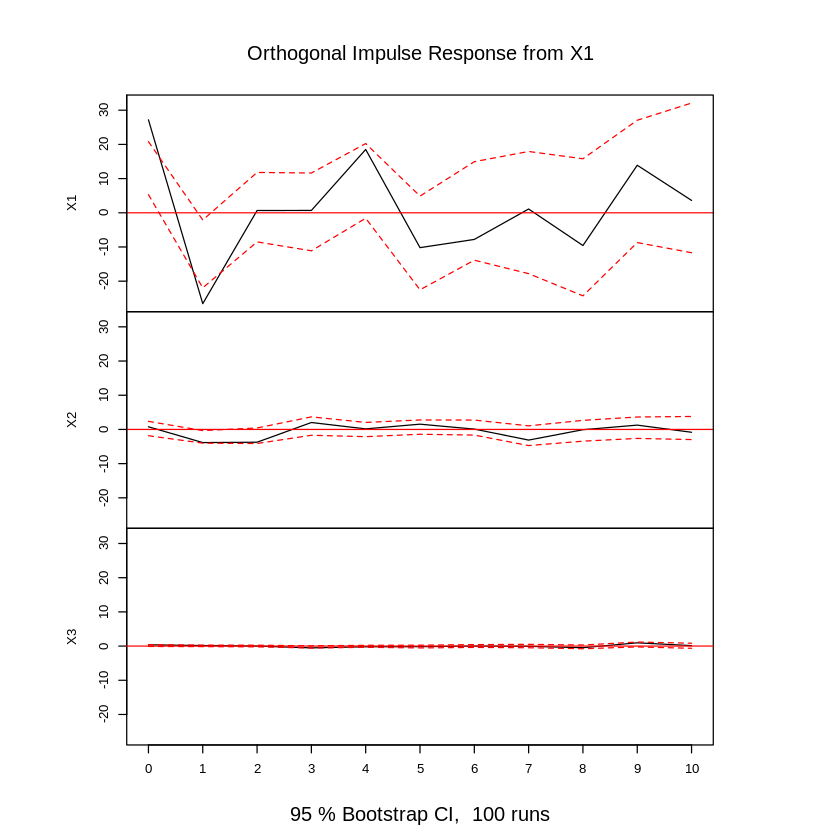

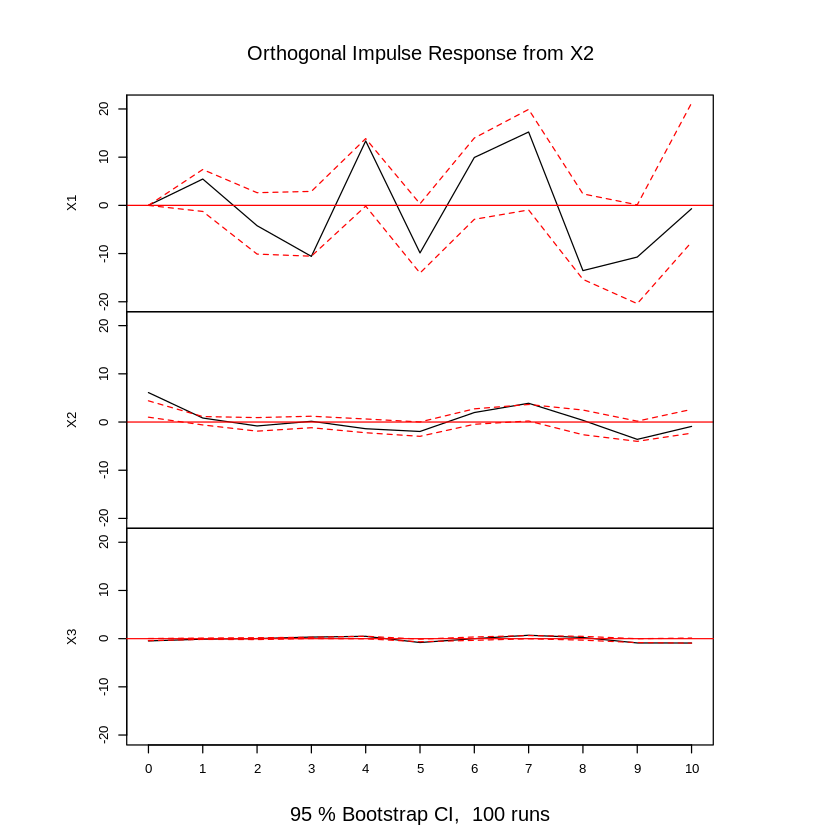

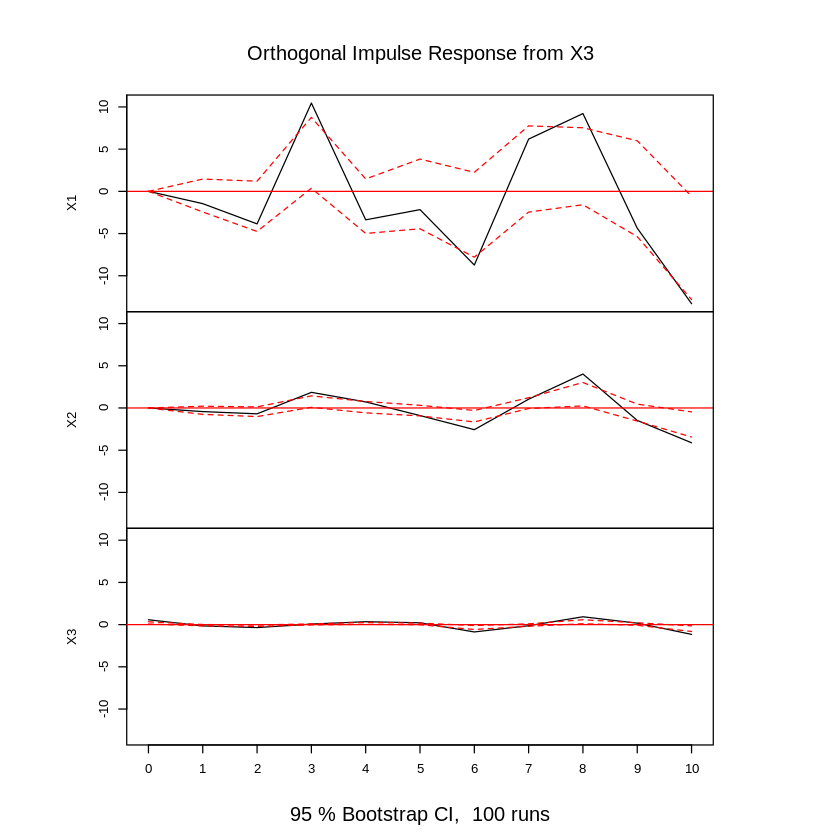

In [140]:
plot(irf(mod))

In [161]:
diff.df.ts

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
2010 Q2,-6,-1,2,0,9,-2,1,1,-1,-3,16,14,4,-3,-4,0,2,3,1,-2,1,2,3,41,67,1
2010 Q3,-5,2,0,0,-45,0,12,2,5,2,11,-63,15,0,17,0,36,-3,0,2,-7,2,5,-23,-35,4
2010 Q4,-1,-9,0,0,38,2,-9,-1,3,1,-27,77,-16,0,-4,0,-47,3,0,0,-6,0,-1,27,14,-3
2011 Q1,-2,46,-1,-1,-17,5,11,-1,-3,-8,2,-21,-3,1,-8,0,2,-1,1,-3,-1,0,-4,-21,-77,-2
2011 Q2,-2,1,0,-2,11,-1,1,1,6,-4,2,-28,-1,-2,-4,0,1,-1,-3,0,6,-2,5,33,51,-2
2011 Q3,-5,-2,1,4,-57,0,-1,-2,2,-1,29,-88,13,-2,-3,0,35,-4,1,3,-2,0,4,-37,-13,3
2011 Q4,-2,0,-2,-7,40,-2,0,1,3,-4,-21,93,-17,2,-5,0,-44,6,-2,0,0,4,-10,10,0,2
2012 Q1,-8,2,-2,-3,7,0,2,1,-3,-7,9,6,-3,1,-3,-7,-4,-4,-1,0,-3,2,-5,-13,3,1
2012 Q2,-2,-1,0,0,4,1,2,1,9,2,6,9,1,-1,-1,0,0,0,2,0,0,-3,-1,41,52,0
2012 Q3,-1,1,0,1,-36,1,-1,1,1,0,38,-53,13,-1,-9,0,30,-5,-1,3,-2,-5,3,-36,-25,0


In [5]:
tmp <-readRDS("VAR_VECM_models/models/1.Rda")

tmp$p

[1] 6